# Introducción

Este conjunto de datos de IBM tiene información sobre los clientes de Telco y si abandonaron la empresa en el último mes (abandono). Cada fila representa un cliente único, mientras que las columnas contienen información sobre los servicios del cliente, la cuenta y los datos demográficos.

In [35]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

In [36]:
df = pd.read_csv("Churn.csv")

In [37]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [39]:
#Cambio el nombre de variables
df.rename(columns = {'customerID':'ClienteID'}, inplace = True)
df.rename(columns = {'gender':'Genero'}, inplace = True)
df.rename(columns = {'SeniorCitizen':'MayorDeEdad'}, inplace = True)
df.rename(columns = {'Partner':'Asociado'}, inplace = True)
df.rename(columns = {'tenure':'Permanencia'}, inplace = True)
df.rename(columns = {'PhoneService':'ServicioTelefónico'}, inplace = True)
df.rename(columns = {'MultipleLines':'MultiplesLineas'}, inplace = True)
df.rename(columns = {'InternetService':'ServiciosInternet'}, inplace = True)
df.rename(columns = {'OnlineSecurity':'SeguridadOnline'}, inplace = True)
df.rename(columns = {'OnlineBackup':'BackupEnLinea'}, inplace = True)
df.rename(columns = {'DeviceProtection':'ProtecciónDispositivos'}, inplace = True)
df.rename(columns = {'TechSupport':'SoporteTecnico'}, inplace = True)
df.rename(columns = {'Contract':'Contrato'}, inplace = True)
df.rename(columns = {'PaperlessBilling':'FacturaciónEnPapel'}, inplace = True)
df.rename(columns = {'PaymentMethod':'MetodoPago'}, inplace = True)
df.rename(columns = {'MonthlyCharges':'MontoMensual'}, inplace = True)
df.rename(columns = {'TotalCharges':'MontoTotal'}, inplace = True)
df.rename(columns = {'Churn':'Abandono'}, inplace = True)

In [46]:
#Creo variables dicotomicas
df["ServicioTelefónicoBi"] = df["ServicioTelefónico"].replace({"No":0,"Yes":1})
df["AbandonoBi"] = df["Abandono"].replace({"No":0,"Yes":1})
df["AsociadoBi"] = df["Asociado"].replace({"No":0,"Yes":1})
df["DependentsBi"] = df["Dependents"].replace({"No":0,"Yes":1})
df["ServicioTelefónicoBi"] = df["ServicioTelefónico"].replace({"No":0,"Yes":1})

In [44]:
#Remplazo de valores nulos nulos en la columna MontoTotal
df['MontoTotal'] = df["MontoTotal"].replace(" ",np.nan)

#Descarto valores nulos de MontoTotal
df = df[df["MontoTotal"].notnull()]
df = df.reset_index()[df.columns]

#Convertir a datos tipo flotante
df["MontoTotal"] = df["MontoTotal"].astype(float)

replace_cols = [ 'SeguridadOnline', 'BackupEnLinea', 'ProtecciónDispositivos',
                'SoporteTecnico','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    df[i]  = df[i].replace({'No internet service' : 'No'})

#Cambio a variable categorica
df["MayorDeEdad"] = df["MayorDeEdad"].replace({1:"Yes",0:"No"})

#Permanencia en variable categoricas
def permanecia(df) :
    
    if df["Permanencia"] <= 12 :
        return "Tenure_0-12"
    elif (df["Permanencia"] > 12) & (df["Permanencia"] <= 24 ):
        return "Tenure_12-24"
    elif (df["Permanencia"] > 24) & (df["Permanencia"] <= 48) :
        return "Tenure_24-48"
    elif (df["Permanencia"] > 48) & (df["Permanencia"] <= 60) :
        return "Tenure_48-60"
    elif df["Permanencia"] > 60 :
        return "Tenure_gt_60"
df["PermanenciaGrupos"] = df.apply(lambda df:permanecia(df),
                                      axis = 1)

#Separar clientes que abandonaron y no abandonaron
abandonaron = df[df["Abandono"]=="Yes"]
no_abandonaron = df[df["Abandono"]=="No"]

#Separa columnas categoricas de numericas
Id_col     = ['ClienteID']
target_col = ["abandono"]
cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]

# Análisis de Datos

## Variable objetivo

In [55]:
df['Abandono'].value_counts(normalize=True)

No     0.734215
Yes    0.265785
Name: Abandono, dtype: float64

Vamos a tratar de predecir si el cliente abandono la empresa. Por lo tanto, tenemos un problema de clasificación binaria con un dataset objetivo desequillibrado:

   * No abandono: 73.42%    
   * Abandono: 26.57%


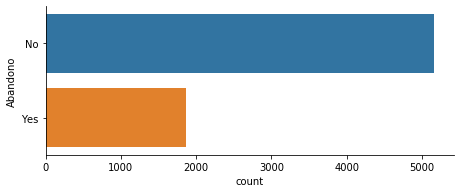

In [62]:
objetivo = sns.catplot(y="Abandono", kind="count", data=df, height=2.6, aspect=2.5, orient='h')

In [73]:
#Etiquetas
lab = df["Abandono"].value_counts().keys().tolist()
#Valores
val = df["Abandono"].value_counts().values.tolist()

trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'darkolivegreen','firebrick'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Customer attrition in data",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

In [ ]:
plt.figure(figsize=(14,12))
cor = round(df.corr(), 2)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)